This notebook tries to see if there is more correlation between EEG to the same image rather than different images

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
DATA_PATH = "/srv/eeg_reconstruction/shared/things_eeg_2/Preprocessed_data_250Hz"
img_directory_training = "/srv/eeg_reconstruction/shared/things_eeg_2/y63gw/osfstorage/training_images"

In [4]:
# Load image and texts
directory = img_directory_training
img_directory = img_directory_training 
dirnames = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
dirnames.sort()

data_list = []
label_list = []
texts = []
images = []

for dir in dirnames:
    try:
        idx = dir.index('_')
        description = dir[idx+1:]  
    except ValueError:
        print(f"Skipped: {dir} due to no '_' found.")
        continue
        
    new_description = f"This picture is {description}"
    texts.append(new_description)

all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]
all_folders.sort()

for folder in all_folders:
    folder_path = os.path.join(img_directory, folder)
    all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_images.sort()  
    images.extend(os.path.join(folder_path, img) for img in all_images)

In [5]:
# load EEGs
subject = 'sub-01'
file_name = 'preprocessed_eeg_training.npy'

file_path = os.path.join(DATA_PATH, subject, file_name)
data = np.load(file_path, allow_pickle=True)

preprocessed_eeg_data = (data['preprocessed_eeg_data'])             
times = data['times'][50:]
ch_names = data['ch_names']  

n_classes = 1654  
samples_per_class = 10  

for i in range(n_classes):
    start_index = i * samples_per_class
    preprocessed_eeg_data_class = preprocessed_eeg_data[start_index: start_index+samples_per_class]
    labels = i  
    data_list.append(preprocessed_eeg_data_class)
    label_list.append(labels)

(10, 4, 63, 250)
500
This picture is feather


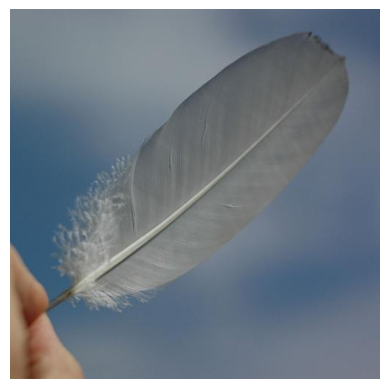

In [30]:
# Total length 1654
category = 500
print(data_list[category].shape)
print(label_list[category])
print(texts[category])
# Total length 16540
imgpath = images[category * 10]
img = mpimg.imread(imgpath)
plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
def find_matching_in_block(dataset):
    seen_ids = {}

    for row in dataset:
        id = row["73k_id"]

        if id in seen_ids:
            return seen_ids[id], row
        
        seen_ids[id] = row
    
    return None, None # return none if none are matching

def find_nonmatching_in_block(dataset):
    block_data_list = list(dataset)

    found = False
    while not found:
        # Randomly select two different rows
        row1, row2 = random.sample(block_data_list, 2)
        found = row1['73k_id'] != row2['73k_id']

    return row1, row2

def corrcoef(eeg1, eeg2):
    return np.array([np.corrcoef(eeg1[i], eeg2[i])[0, 1] for i in range(63)])


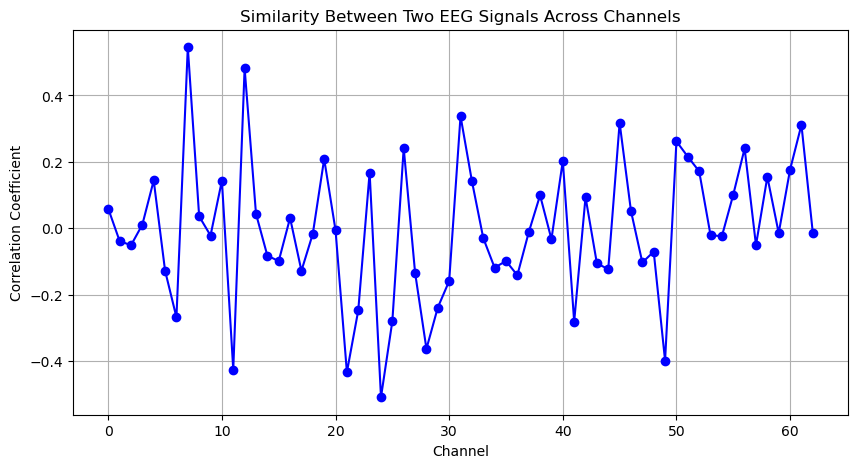

Average similarity across all channels: -0.00


In [37]:
# Get similarities
same1, same2 = data_list[15][0][0], data_list[15][0][1]
similarities = corrcoef(same1, same2)
# Average similarity
average_similarity = np.mean(similarities)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(similarities, marker='o', linestyle='-', color='b')
plt.title('Similarity Between Two EEG Signals Across Channels')
plt.xlabel('Channel')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

print(f"Average similarity across all channels: {average_similarity:.2f}")

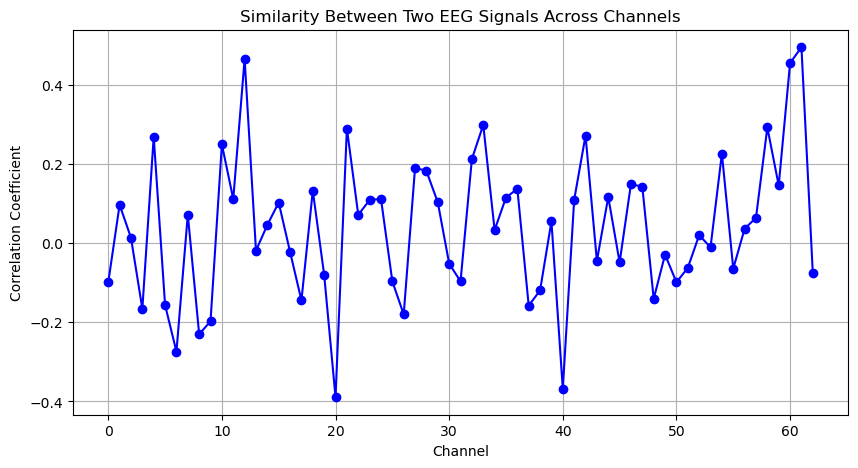

Average similarity across all channels: 0.04


In [35]:
# Get similarities
diff1, diff2 = data_list[500][0][1], data_list[15][0][1]
similarities = corrcoef(diff1, diff2)
# Average similarity
average_similarity = np.mean(similarities)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(similarities, marker='o', linestyle='-', color='b')
plt.title('Similarity Between Two EEG Signals Across Channels')
plt.xlabel('Channel')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

print(f"Average similarity across all channels: {average_similarity:.2f}")

# Correlation coefficient

In [40]:
import random

def generate_pairs(eeg):
    same_id_pairs = []
    different_id_pairs = []
    totalCount = 100

    for i in range(totalCount):
        category1 = random.randint(0, len(eeg)-1)
        category2 = random.randint(0, len(eeg)-1)
        if category1 == category2:
            category2 += 1
        
        # First image from the category, first and second response
        same_pair = (eeg[category1][0][0], eeg[category1][0][1])
        same_id_pairs.append(same_pair)

        diff_pair = (eeg[category1][0][0], eeg[category2][0][0])
        different_id_pairs.append(diff_pair)
    
    return same_id_pairs, different_id_pairs

def calculate_correlations(pairs):
    correlations = []
    for row1, row2 in pairs:
        correlation = corrcoef(row1, row2)
        correlations.append(correlation)
    return correlations


In [41]:
matching_correlations = []
nonmatching_correlations = []

# Assuming 'dataset' is a list of dictionaries and 'block' is a valid key
same_id_pairs, different_id_pairs = generate_pairs(data_list)

matching_correlations.extend(calculate_correlations(same_id_pairs))
nonmatching_correlations.extend(calculate_correlations(different_id_pairs))


T-statistic: 1.050442389404961, P-value: 0.2947951727067822


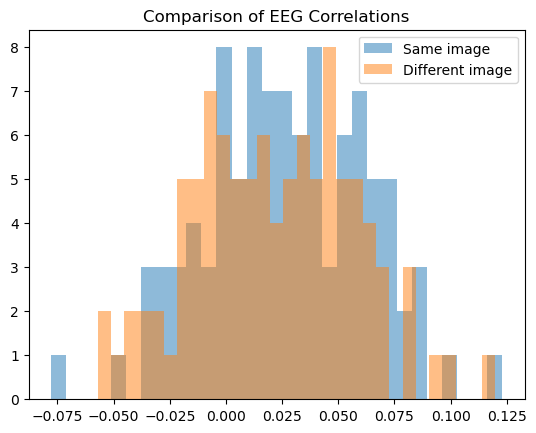

In [48]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Example of T-test
t_stat, p_value = ttest_ind([np.mean(corr) for corr in matching_correlations],
                            [np.mean(corr) for corr in nonmatching_correlations], equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting histograms
plt.hist([np.mean(corr) for corr in matching_correlations], bins=30, alpha=0.5, label='Same image')
plt.hist([np.mean(corr) for corr in nonmatching_correlations], bins=30, alpha=0.5, label='Different image')
plt.legend()
plt.title('Comparison of EEG Correlations')
plt.show()


# Coherence

T-statistic: -1.2371943556409213, P-value: 0.2174868985176265


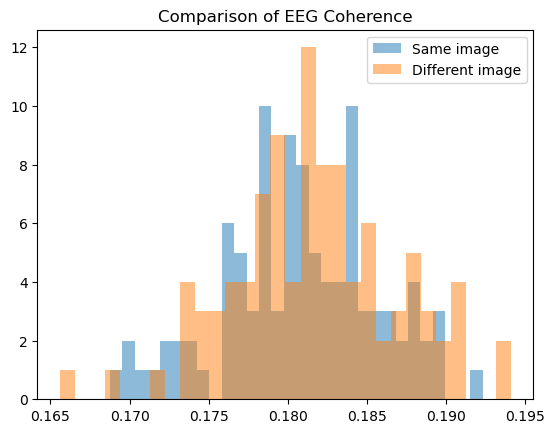

In [49]:
from scipy.signal import coherence

# Assuming 'same_id_pairs' and 'different_id_pairs' are lists of tuples,
# where each tuple contains two numpy arrays representing EEG data from two channels.

def calculate_coherence(pairs):
    coherence_values = []
    for (data1, data2) in pairs:
        f, Cxy = coherence(data1, data2, fs=512, nperseg=64)  # Adjust fs and nperseg according to your dataset
        mean_coherence = np.mean(Cxy)
        coherence_values.append(mean_coherence)
    return coherence_values

# Calculate coherence for matching and nonmatching pairs
matching_coherence = calculate_coherence(same_id_pairs)
nonmatching_coherence = calculate_coherence(different_id_pairs)

# Perform T-test on the mean coherence values
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(matching_coherence, nonmatching_coherence, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Plotting histograms of coherence values
plt.hist(matching_coherence, bins=30, alpha=0.5, label='Same image')
plt.hist(nonmatching_coherence, bins=30, alpha=0.5, label='Different image')
plt.legend()
plt.title('Comparison of EEG Coherence')
plt.show()


# Dynamic Time Warping

DTW T-statistic: -0.25133305590025756, DTW P-value: 0.8018175135481315


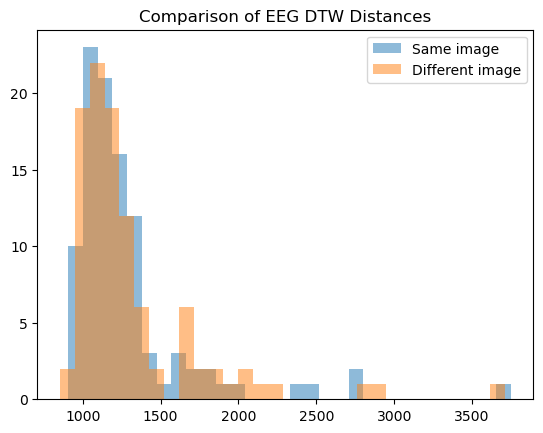

In [50]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Function to calculate DTW distance between pairs
def calculate_dtw(pairs):
    dtw_distances = []
    for (data1, data2) in pairs:
        distance, path = fastdtw(data1, data2, dist=euclidean)
        dtw_distances.append(distance)
    return dtw_distances

# Calculate DTW distances
matching_dtw_distances = calculate_dtw(same_id_pairs)
nonmatching_dtw_distances = calculate_dtw(different_id_pairs)

# Example of T-test on DTW distances
from scipy.stats import ttest_ind
t_stat_dtw, p_value_dtw = ttest_ind(matching_dtw_distances, nonmatching_dtw_distances, equal_var=False)
print(f"DTW T-statistic: {t_stat_dtw}, DTW P-value: {p_value_dtw}")

# Plotting histograms for DTW distances
import matplotlib.pyplot as plt
plt.hist(matching_dtw_distances, bins=30, alpha=0.5, label='Same image')
plt.hist(nonmatching_dtw_distances, bins=30, alpha=0.5, label='Different image')
plt.legend()
plt.title('Comparison of EEG DTW Distances')
plt.show()
